In [1]:
%matplotlib inline

import torch
import random
import copy
import numpy as np
import pandas as pd
import seaborn as sns

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.autograd import Variable
from torchvision import datasets, transforms
from operator import itemgetter
from tqdm import tqdm, tnrange, tqdm_notebook
from bogus import atk

sns.set()

In [2]:
transform = transforms.Compose([
                       transforms.ToTensor()])

MNIST_train = datasets.MNIST(r'D:\Data_sets/MNIST', 
                            train=True, download=True,
                            transform=transform)

MNIST_test = datasets.MNIST(r'D:\Data_sets/MNIST', 
                            train=False, download=True,
                            transform=transform)

train_loader = torch.utils.data.DataLoader(
                            MNIST_train, batch_size=64, 
                            shuffle=True, pin_memory=True)

test_loader = torch.utils.data.DataLoader(MNIST_test,
                            batch_size=1000, shuffle=True, 
                            pin_memory=True)

In [3]:
def test(model, test_loader, adv_func=None, adversarial=False, eps=0.5):
    """
    Test model

    Args:
    test_loader: a PyTorch dataloader to test on
    adv_func: a function that returns adversarial examples 
    """
    model.train(False)
    
    test_loss = 0
    correct = 0

    criterion = nn.CrossEntropyLoss()
    
    if adversarial:
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            data= adv_func(model, data, target, eps=eps, single=True)
            output = model(data)
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred).cuda()).sum().item()
            test_loss += criterion(output, target).item()
        
    else:
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.cuda(), target.cuda()
                output = model(data)
                test_loss += criterion(output, target).item()
                pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    
    
    return (test_loss, correct)

In [4]:
img = next(iter(test_loader))[0][0]

In [5]:
class NNet(nn.Module):
    def __init__(self):
        super(NNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        #self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def logits_forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        #x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        #x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [6]:
def mutate(x, chance, mean, std):
    if np.random.rand() > (1-chance): 
        x = np.random.normal(loc=mean, scale=std)
        return x
    return x

In [7]:
def update_weights(params, chance):
    std = params.detach().std()
    return params.detach().apply_(lambda x: mutate(x, chance, x, std))

In [8]:
def mutate_weights(model, chance):
    model.cpu()
    params = list(model.parameters())
    for param in params:
        if len(param.shape) == 1:
            param.data = update_weights(param, chance)
        elif len(param.shape) == 2:
            for inner_param in param:
                    inner_param.data = update_weights(inner_param, chance)
        else:
            for inner_param in param:
                for last_channel in inner_param:
                    last_channel.data = update_weights(last_channel, chance)
    model.cuda()

In [9]:
def crossover(model1, model2):
    
    mod1 = copy.deepcopy(model1)
    mod2 = copy.deepcopy(model2)
    
    model1_params = list(mod1.parameters())
    model2_params = list(mod2.parameters())
    
    for i, param in enumerate(model1_params):
        if len(param.shape) == 1:
            split = int(np.random.uniform(low=0, high=param.shape[0]))
            first_half = param.view(-1)[:split].data 
            second_half = model2_params[i].view(-1)[split:].data
            comb = torch.cat((first_half, second_half)).view_as(param)
            first_half = param.view(-1)[split:].data
            second_half = model2_params[i].view(-1)[:split].data
            comb2 = torch.cat((first_half, second_half)).view_as(param)
            param.data = comb
            model2_params[i].data = comb2
        
        elif len(param.shape) == 2:
             for j, inner_param in enumerate(param):
                split = int(np.random.uniform(low=0, high=inner_param.shape[0]))
                first_half = inner_param.view(-1)[:split].data 
                second_half = model2_params[i][j].view(-1)[split:].data
                comb = torch.cat((first_half, second_half)).view_as(inner_param)
                first_half = inner_param.view(-1)[split:].data
                second_half = model2_params[i][j].view(-1)[:split].data
                comb2 = torch.cat((first_half, second_half)).view_as(inner_param)
                inner_param.data = comb
                model2_params[i][j].data = comb2

        else:
            for j, inner_param in enumerate(param):
                for k, last_channel in enumerate(inner_param):
                    split = int(np.random.uniform(low=0, 
                                high=last_channel.shape[0] * last_channel.shape[1]))
                    first_half = last_channel.view(-1)[:split].data 
                    second_half = model2_params[i][j][k].view(-1)[split:].data
                    comb = torch.cat((first_half, second_half)).view_as(last_channel)
                    first_half = last_channel.view(-1)[split:].data
                    second_half = model2_params[i][j][k].view(-1)[:split].data
                    comb2 = torch.cat((first_half, second_half)).view_as(last_channel)
                    last_channel.data = comb
                    model2_params[i][j][k].data = comb2
                    
        return mod1, mod2

In [10]:
class GeneticWeightOptimizer:

    def __init__(self, population_sz, test_fn, test_loader, adv_func, RUN):
        
        self.test = test_fn
        self.testloader = test_loader
        self.population_sz = population_sz
        self.adv_func = adv_func
        self.run = RUN
        self.best_correct = correct
        self.best_params
        
        torch.manual_seed(1)
        
        self.population = [NNet().cuda() for i in range(self.population_sz)]

        self.test_results = {} 
        self.generation = 0

    def step(self, generations=1, save=False, phone=False):

        for _ in tnrange(generations, desc='Overall progress'): #tqdm progress bar

            self.generation += 1
            self.children = []
            
            self.evaluate_nets()

            mean = np.mean(self.test_results[self.generation]['correct'])
            best = np.max(self.test_results[self.generation]['correct'])

            tqdm.write('Generation {} Population mean:{} max:{}'
                       .format(self.generation, mean, best))


            n_elite = 2
            sorted_pop = np.argsort(self.test_results[self.generation]['correct'])[::-1]
            elite = sorted_pop[:n_elite]
            
            # elites always included in the next population
            self.elite = []
            print('\nTop performers:')
            for no, i in enumerate(elite):
                self.elite.append((self.test_results[self.generation]['correct'][i], 
                                   self.population[i]))    

                self.children.append(self.population[i])

                tqdm.write("{}: score:{} \n".format(no,
                            self.test_results[self.generation]['correct'][i]))   


            #https://stackoverflow.com/questions/31933784/tournament-selection-in-genetic-algorithm
            p = 0.85 # winner probability 
            tournament_size = 5
            probs = [p*((1-p)**i) for i in range(tournament_size-1)]
            probs.append(1-np.sum(probs))
            #probs = [0.85, 0.1275, 0.0224,  0.01913, 0.00286, 0.000506]

            while len(self.children) < self.population_sz:
                pop = range(len([i for i in range(self.population_sz)]))
                sel_k = random.sample(pop, k=5)
                fitness_k = list(np.array(self.test_results[self.generation]['correct'])[sel_k] *
                                 np.array(self.test_results[self.generation]['clean_correct'])[sel_k])
                selected = zip(sel_k, fitness_k)
                rank = sorted(selected, key=itemgetter(1), reverse=True)
                picks = np.random.choice(tournament_size, size=2, p=probs, replace=False)
                parent1 = rank[picks[0]]
                parent2 = rank[picks[1]]
                bestmodel1 = self.population[parent1[0]]
                bestmodel2 = self.population[parent2[0]]
                child1, child2 = crossover(bestmodel1, bestmodel2)
                mutate_weights(child1, 0.01)
                mutate_weights(child2, 0.01)
                self.children.append(child1)
                self.children.append(child2)
                
            self.population = self.children
            
    def evaluate_nets(self):
        """evaluate the models."""

        losses = []
        corrects = []
        clean_corrects = []

        self.test_results[self.generation] = {}

        for i in range(len(self.population)):
            net = self.population[i]
            loss, correct = self.test(net, self.testloader, adv_func=self.adv_func,
                                    adversarial=True, eps=0.1) #Return to adversarial later
            _, clean_correct = self.test(net, self.testloader)
            
            if correct > self.best_correct:
                self.best_correct = correct
                self.best_params = copy.deepcopy(list(net.parameters()))

            corrects.append(correct)
            clean_corrects.append(clean_correct)

        self.test_results[self.generation]['correct'] = corrects
        self.test_results[self.generation]['clean_correct'] = clean_corrects

In [11]:
atk_func = atk().fgsm

In [12]:
test1 = GeneticWeightOptimizer(50, test, test_loader, atk_func, RUN=1)

In [13]:
test1.step(generations=700)

Generation 1 Population mean:477.12 max:1135

Top performers:
0: score:1135 

1: score:1135 

Generation 2 Population mean:771.88 max:1135

Top performers:
0: score:1135 

1: score:1135 

Generation 3 Population mean:1008.74 max:1135

Top performers:
0: score:1135 

1: score:1135 

Generation 4 Population mean:1113.58 max:1135

Top performers:
0: score:1135 

1: score:1135 

Generation 5 Population mean:1127.44 max:1135

Top performers:
0: score:1135 

1: score:1135 

Generation 6 Population mean:1127.84 max:1135

Top performers:
0: score:1135 

1: score:1135 

Generation 7 Population mean:1122.12 max:1135

Top performers:
0: score:1135 

1: score:1135 

Generation 8 Population mean:1122.56 max:1135

Top performers:
0: score:1135 

1: score:1135 

Generation 9 Population mean:1123.24 max:1135

Top performers:
0: score:1135 

1: score:1135 

Generation 10 Population mean:1116.5 max:1135

Top performers:
0: score:1135 

1: score:1135 

Generation 11 Population mean:1127.02 max:1137

Top 

Top performers:
0: score:2039 

1: score:2038 

Generation 87 Population mean:1916.22 max:2039

Top performers:
0: score:2039 

1: score:2039 

Generation 88 Population mean:1951.88 max:2039

Top performers:
0: score:2039 

1: score:2039 

Generation 89 Population mean:1911.06 max:2039

Top performers:
0: score:2039 

1: score:2039 

Generation 90 Population mean:1940.62 max:2039

Top performers:
0: score:2039 

1: score:2039 

Generation 91 Population mean:1923.8 max:2046

Top performers:
0: score:2046 

1: score:2039 

Generation 92 Population mean:1877.4 max:2046

Top performers:
0: score:2046 

1: score:2043 

Generation 93 Population mean:1889.3 max:2046

Top performers:
0: score:2046 

1: score:2043 

Generation 94 Population mean:1935.82 max:2046

Top performers:
0: score:2046 

1: score:2043 

Generation 95 Population mean:1922.72 max:2046

Top performers:
0: score:2046 

1: score:2043 

Generation 96 Population mean:1964.16 max:2057

Top performers:
0: score:2057 

1: score:20

Generation 171 Population mean:2027.2 max:2086

Top performers:
0: score:2086 

1: score:2085 

Generation 172 Population mean:2020.98 max:2086

Top performers:
0: score:2086 

1: score:2085 

Generation 173 Population mean:2014.86 max:2086

Top performers:
0: score:2086 

1: score:2085 

Generation 174 Population mean:2009.42 max:2086

Top performers:
0: score:2086 

1: score:2085 

Generation 175 Population mean:2042.98 max:2086

Top performers:
0: score:2086 

1: score:2085 

Generation 176 Population mean:2020.7 max:2086

Top performers:
0: score:2086 

1: score:2085 

Generation 177 Population mean:2025.52 max:2086

Top performers:
0: score:2086 

1: score:2085 

Generation 178 Population mean:2045.86 max:2086

Top performers:
0: score:2086 

1: score:2085 

Generation 179 Population mean:2030.02 max:2086

Top performers:
0: score:2086 

1: score:2085 

Generation 180 Population mean:2025.38 max:2087

Top performers:
0: score:2087 

1: score:2086 

Generation 181 Population mean:2

Top performers:
0: score:2098 

1: score:2098 

Generation 256 Population mean:2041.42 max:2098

Top performers:
0: score:2098 

1: score:2098 

Generation 257 Population mean:2019.06 max:2098

Top performers:
0: score:2098 

1: score:2098 

Generation 258 Population mean:2032.3 max:2098

Top performers:
0: score:2098 

1: score:2098 

Generation 259 Population mean:2011.24 max:2098

Top performers:
0: score:2098 

1: score:2098 

Generation 260 Population mean:2017.66 max:2098

Top performers:
0: score:2098 

1: score:2098 

Generation 261 Population mean:2040.26 max:2099

Top performers:
0: score:2099 

1: score:2098 

Generation 262 Population mean:2017.54 max:2099

Top performers:
0: score:2099 

1: score:2098 

Generation 263 Population mean:2014.46 max:2099

Top performers:
0: score:2099 

1: score:2098 

Generation 264 Population mean:2011.66 max:2099

Top performers:
0: score:2099 

1: score:2098 

Generation 265 Population mean:2028.94 max:2099

Top performers:
0: score:2099 


Generation 340 Population mean:2026.54 max:2101

Top performers:
0: score:2101 

1: score:2101 

Generation 341 Population mean:2010.44 max:2101

Top performers:
0: score:2101 

1: score:2101 

Generation 342 Population mean:2011.24 max:2101

Top performers:
0: score:2101 

1: score:2101 

Generation 343 Population mean:2011.7 max:2101

Top performers:
0: score:2101 

1: score:2101 

Generation 344 Population mean:1995.92 max:2101

Top performers:
0: score:2101 

1: score:2101 

Generation 345 Population mean:2050.28 max:2101

Top performers:
0: score:2101 

1: score:2101 

Generation 346 Population mean:2029.86 max:2101

Top performers:
0: score:2101 

1: score:2101 

Generation 347 Population mean:2046.42 max:2101

Top performers:
0: score:2101 

1: score:2101 

Generation 348 Population mean:2042.02 max:2101

Top performers:
0: score:2101 

1: score:2101 

Generation 349 Population mean:2048.42 max:2101

Top performers:
0: score:2101 

1: score:2101 

Generation 350 Population mean:

Top performers:
0: score:2101 

1: score:2101 

Generation 425 Population mean:2001.8 max:2101

Top performers:
0: score:2101 

1: score:2101 

Generation 426 Population mean:2015.1 max:2101

Top performers:
0: score:2101 

1: score:2101 

Generation 427 Population mean:2002.26 max:2101

Top performers:
0: score:2101 

1: score:2101 

Generation 428 Population mean:2051.54 max:2101

Top performers:
0: score:2101 

1: score:2101 

Generation 429 Population mean:2014.52 max:2101

Top performers:
0: score:2101 

1: score:2101 

Generation 430 Population mean:2051.4 max:2101

Top performers:
0: score:2101 

1: score:2101 

Generation 431 Population mean:2049.14 max:2101

Top performers:
0: score:2101 

1: score:2101 

Generation 432 Population mean:2041.66 max:2101

Top performers:
0: score:2101 

1: score:2101 

Generation 433 Population mean:2042.94 max:2101

Top performers:
0: score:2101 

1: score:2101 

Generation 434 Population mean:2051.1 max:2101

Top performers:
0: score:2101 

1:

Generation 509 Population mean:1997.86 max:2102

Top performers:
0: score:2102 

1: score:2102 

Generation 510 Population mean:2043.04 max:2102

Top performers:
0: score:2102 

1: score:2102 

Generation 511 Population mean:2037.94 max:2102

Top performers:
0: score:2102 

1: score:2102 

Generation 512 Population mean:2019.36 max:2102

Top performers:
0: score:2102 

1: score:2102 

Generation 513 Population mean:2008.84 max:2102

Top performers:
0: score:2102 

1: score:2102 

Generation 514 Population mean:2022.06 max:2102

Top performers:
0: score:2102 

1: score:2102 

Generation 515 Population mean:2021.74 max:2102

Top performers:
0: score:2102 

1: score:2102 

Generation 516 Population mean:2021.02 max:2102

Top performers:
0: score:2102 

1: score:2102 

Generation 517 Population mean:2056.34 max:2102

Top performers:
0: score:2102 

1: score:2102 

Generation 518 Population mean:1995.76 max:2102

Top performers:
0: score:2102 

1: score:2102 

Generation 519 Population mean

Top performers:
0: score:2107 

1: score:2106 

Generation 594 Population mean:2027.4 max:2107

Top performers:
0: score:2107 

1: score:2106 

Generation 595 Population mean:2050.76 max:2107

Top performers:
0: score:2107 

1: score:2106 

Generation 596 Population mean:2066.06 max:2107

Top performers:
0: score:2107 

1: score:2106 

Generation 597 Population mean:2059.68 max:2107

Top performers:
0: score:2107 

1: score:2106 

Generation 598 Population mean:2059.46 max:2107

Top performers:
0: score:2107 

1: score:2106 

Generation 599 Population mean:2011.5 max:2107

Top performers:
0: score:2107 

1: score:2106 

Generation 600 Population mean:2042.68 max:2107

Top performers:
0: score:2107 

1: score:2106 

Generation 601 Population mean:2007.12 max:2107

Top performers:
0: score:2107 

1: score:2106 

Generation 602 Population mean:2046.08 max:2107

Top performers:
0: score:2107 

1: score:2106 

Generation 603 Population mean:2036.64 max:2107

Top performers:
0: score:2107 



Generation 678 Population mean:2053.22 max:2107

Top performers:
0: score:2107 

1: score:2106 

Generation 679 Population mean:2069.52 max:2107

Top performers:
0: score:2107 

1: score:2106 

Generation 680 Population mean:2040.78 max:2107

Top performers:
0: score:2107 

1: score:2106 

Generation 681 Population mean:2051.78 max:2107

Top performers:
0: score:2107 

1: score:2106 

Generation 682 Population mean:1983.24 max:2107

Top performers:
0: score:2107 

1: score:2106 

Generation 683 Population mean:2024.24 max:2107

Top performers:
0: score:2107 

1: score:2106 

Generation 684 Population mean:2061.44 max:2107

Top performers:
0: score:2107 

1: score:2106 

Generation 685 Population mean:2038.24 max:2107

Top performers:
0: score:2107 

1: score:2106 

Generation 686 Population mean:2034.24 max:2107

Top performers:
0: score:2107 

1: score:2106 

Generation 687 Population mean:1998.52 max:2107

Top performers:
0: score:2107 

1: score:2106 

Generation 688 Population mean

In [28]:
def progressplotter(optimizer, clean=False):
    
    if clean:
        dataset = 'clean_correct'
    else:
        dataset = 'correct'
    
    means = []
    
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    
    gens = range(len(optimizer.test_results))
    popsize = len(optimizer.test_results[1][dataset])
    
    for i in gens:
        ax.scatter([i for j in range(popsize)], np.array(optimizer.test_results[i+1][dataset])/100)
        mean = np.mean(optimizer.test_results[i+1][dataset]) / 100
        means.append(mean)
        ax.scatter(i, mean, c=1)
        
        if i == 0:
            continue
        plt.plot([i-1, i], [means[i-1], mean], c='black')
        
    ax.set_xticks(np.arange(0, len(means),1))
    ax.set_xlabel('Generation')
    ax.set_ylabel('Correct classifications (%)' )
    
    if clean:
        ax.set_title('Accuracy on clean dataset')
    else:
        ax.set_title('Accuracy on adversarial dataset')
    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
        item.set_fontsize(30)
        
    for item in (ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(15)

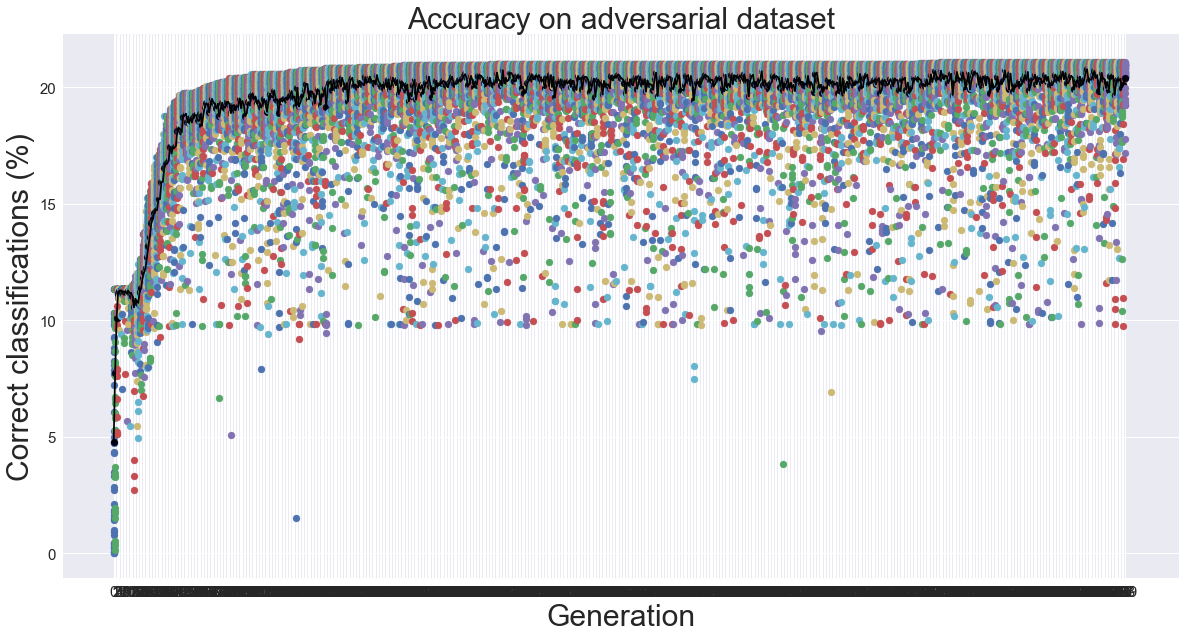

In [29]:
progressplotter(test1)

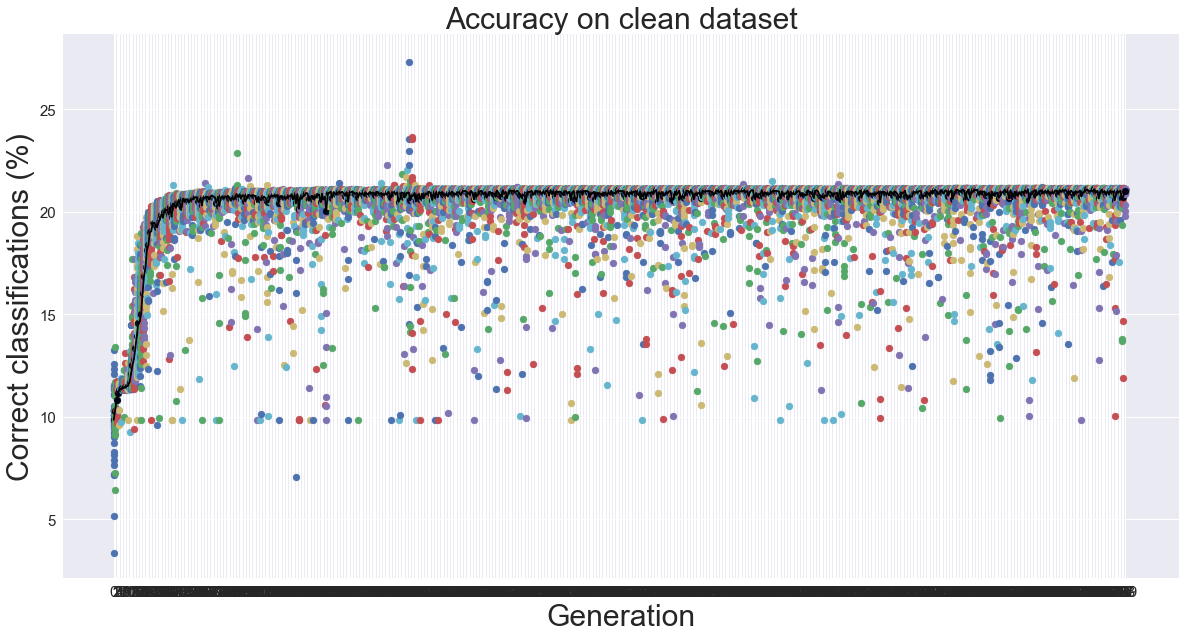

In [30]:
progressplotter(test1, clean=True)